In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle

datapath = 'data/'

In [2]:
!ls data/stage_1_train_images/ | wc


  25684   25684 1053044


In [3]:
df_box = pd.read_csv(datapath+'stage_1_train_labels.csv')
print('Number of rows (unique boxes per patient) in main train dataset:', df_box.shape[0])
print('Number of unique patient IDs:', df_box['patientId'].nunique())
df_box.head(6)

Number of rows (unique boxes per patient) in main train dataset: 28989
Number of unique patient IDs: 25684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Target
0    0.690779
1    0.309221
dtype: float64


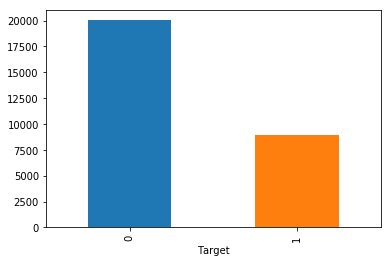

In [4]:
df_box.groupby('Target').size().plot.bar()
print(df_box.groupby('Target').size() / df_box.shape[0])


In [5]:
df_aux = pd.read_csv(datapath+'stage_1_detailed_class_info.csv')
print('Number of rows in auxiliary dataset:', df_aux.shape[0])
print('Number of unique patient IDs:', df_aux['patientId'].nunique())
df_aux.head(6)

Number of rows in auxiliary dataset: 28989
Number of unique patient IDs: 25684


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class
Lung Opacity                    0.309221
No Lung Opacity / Not Normal    0.396702
Normal                          0.294077
dtype: float64


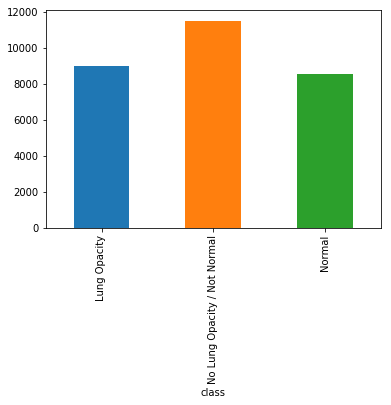

In [6]:
df_aux.groupby('class').size().plot.bar()
print(df_aux.groupby('class').size() / df_aux.shape[0])
assert df_box.loc[df_box['Target']==0].shape[0] == df_aux.loc[df_aux['class'].isin(['Normal', \
    'No Lung Opacity / Not Normal'])].shape[0], 'Number of negative targets does not match between main and auxiliary dataset.'
assert df_box.loc[df_box['Target']==1].shape[0] == df_aux.loc[df_aux['class'] == 'Lung Opacity'].shape[0], \
    'Number of positive targets does not match between main and auxiliary dataset.'

In [7]:
assert df_box['patientId'].values.tolist() == df_aux['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_box, df_aux.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity


In [8]:
df_train.groupby(['class', 'Target']).size()


class                         Target
Lung Opacity                  1          8964
No Lung Opacity / Not Normal  0         11500
Normal                        0          8525
dtype: int64

In [9]:
df_train.isnull().any()


patientId    False
x             True
y             True
width         True
height        True
Target       False
class        False
dtype: bool

In [10]:
# when target==1, are any of the box coordinates null? (should all be false)
df_train.loc[df_train['Target']==1, ['x', 'y', 'width', 'height']].isnull().any()

x         False
y         False
width     False
height    False
dtype: bool

In [11]:
# when target==0, are all of the box coordinates null? (should all be true)
df_train.loc[df_train['Target']==0, ['x', 'y', 'width', 'height']].isnull().all()

x         True
y         True
width     True
height    True
dtype: bool

In [12]:
# sample of image filenames
!ls -U data/stage_1_train_images/ | head -6

dce40126-49cb-444e-99fc-a5d5546569de.dcm
d309f369-5cb4-4ad6-8b6b-316a1a973405.dcm
5f74d71f-3b73-4748-b7df-cc6374890c57.dcm
44da3869-4815-4f7c-9350-a396d9961443.dcm
582e641d-ac17-43b5-89a0-453555dd152e.dcm
c490db79-e265-4196-9b80-f69278d197bc.dcm
ls: write error: Broken pipe


In [13]:
# check that there is an image for each unique patient ID
assert sorted(df_train['patientId'].unique().tolist()) == sorted([f[:-4] for f in os.listdir(datapath+'stage_1_train_images/')]), \
    'Discrepancy between patient IDs and radiograph images.'

In [14]:
# have a look at the header meta-data of an image 
pId = df_train['patientId'].sample(1).values[0]    
dcmdata = pydicom.read_file(datapath+'stage_1_train_images/'+pId+'.dcm')
print(dcmdata)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14528.1517874380.26212
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '3a010152-9ce2-4780-bdd8-bac6fa101991'
(0010, 0020) Patient ID                          LO: '3a010152-9ce2-4780-bdd8-bac6fa101991'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [15]:
# extract the raw pixel image and look at its properties
dcmimg = dcmdata.pixel_array
print(type(dcmimg))
print(dcmimg.dtype)
print(dcmimg.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

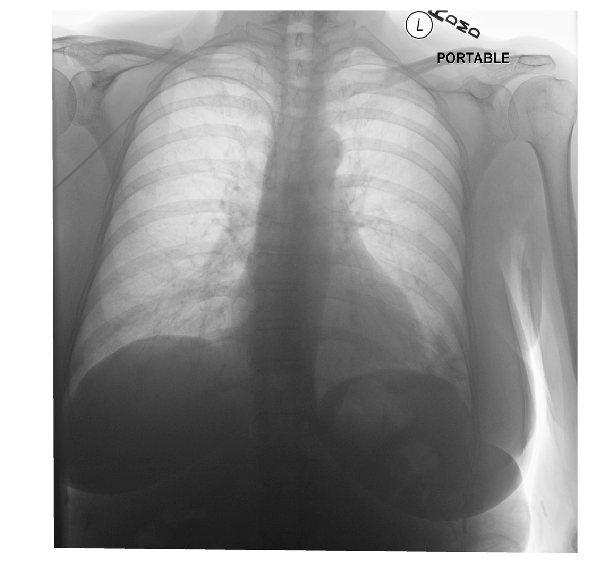

In [17]:
# visualize the corresponding radiograph image
plt.figure(figsize=(20,10))
plt.imshow(dcmimg, cmap=pylab.cm.binary)
plt.axis('off')

In [18]:
def get_boxes_per_patient(df, pId):
    '''
    Given the dataset and one patient ID, 
    return an array of all the bounding boxes and their labels associated with that patient ID.
    Example of return: 
    array([[x1, y1, width1, height1, class1, target1],
           [x2, y2, width2, height2, class2, target2]])
    '''
    
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height', 'class', 'Target']].values
    return boxes

In [19]:
def get_dcm_data_per_patient(pId, sample='train'):
    '''
    Given one patient ID and the sample name (train/test), 
    return the corresponding dicom data.
    '''
    return pydicom.read_file(datapath+'stage_1_'+sample+'_images/'+pId+'.dcm')

In [20]:
def display_image_per_patient(df, pId, angle=0.0, sample='train'):
    '''
    Given one patient ID and the dataset,
    display the corresponding dicom image with overlaying boxes and class annotation.
    To be implemented: Optionally input the image rotation angle, in case of data augmentation.
    '''
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    dcmimg = dcmdata.pixel_array
    boxes = get_boxes_per_patient(df, pId)
    plt.figure(figsize=(20,10))
    plt.imshow(dcmimg, cmap=pylab.cm.binary)
    plt.axis('off')
    
    class_color_dict = {'Normal' : 'green',
                        'No Lung Opacity / Not Normal' : 'orange',
                        'Lung Opacity' : 'red'}

    if len(boxes)>0:
        for box in boxes:
            # extracting individual coordinates and labels
            x, y, w, h, c, t = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', 
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            plt.gca().add_patch(patch)
            
    # add annotation text
    plt.text(10, 50, c, color=class_color_dict[c], size=20, 
             bbox=dict(edgecolor=class_color_dict[c], facecolor='none', alpha=0.5, lw=2))
          

In [40]:
pId

'6365ff26-72cf-4428-8610-66aab9c787c9'

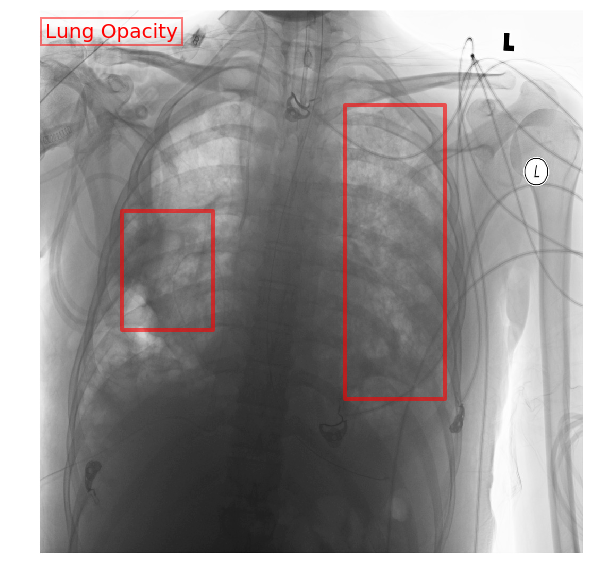

In [39]:

# run this cell multiple times to visualize different examples
pId = df_train['patientId'].sample(1).values[0]    
display_image_per_patient(df_train, pId, sample='train')

In [23]:
def get_metadata_per_patient(pId, attribute, sample='train'):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [29]:
df_train

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity


In [26]:
# create list of attributes that we want to extract (manually edited after checking which attributes contained valuable information)
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    df_train[a] = df_train['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='train'))
# convert patient age from string to numeric
df_train['PatientAge'] = df_train['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
df_train['PatientAge'] = df_train['PatientAge'].apply(lambda x: x if x<120 else np.nan)
df_train.head()

PatientSex


KeyboardInterrupt: 